# 4장 신경망 학습

- 손실함수 값을 가급적이면 가장 작게 만드는 기법! : 경사법
- 오차제곱합, 교차 엔트로피

### 4.2.1 오차제곱합
- 원 핫 인코딩 : 한 원소만 1, 나머지는 다 0으로 표기하는 방법

In [1]:
y=[0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
t=[0,0,1,0,0,0,0,0,0,0]

In [2]:
def sum_squares_error(y,t):
    return 0.5*np.sum((y-t)**2)

In [1]:
import numpy as np
import matplotlib.pylab as plt

### 4.3 편미분

In [8]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)  # x와 형상이 같은 배열을 생성

    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 값 복원

    return grad

In [9]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [10]:

print(numerical_gradient(function_2, np.array([3.0, 4.0])))  # [ 6.  8.]
print(numerical_gradient(function_2, np.array([0.0, 2.0])))  # [ 0.  4.]
print(numerical_gradient(function_2, np.array([3.0, 0.0])))  # [ 6.  0.]

[6. 8.]
[0. 4.]
[6. 0.]


변수가 2개일때 어느 변수에 대한 미분이냐를 구분해야하고, 덧붙여 이와같이 변수가 여럿인 함수에 대한 미분을 편미분이라고 한다.  
편미분은 변수가 하나인 미분과 마찬가지로 특정 장소의 기울기를 구한다.

### 4.4.1 경사법(경사 하강법)
기계학습 문제 대부분은 학습단계에서 최적의 매개변수를 찾아낸다. 신경망 역시 최적의 매개변수(가중치와 편향)를 학습시에 찾아야 한다.  
최적 : 손실함수가 최솟값이 될 때의 매개변수 값!  
기울기를 잘 이용해 함수의 최솟값을 찾으려는 것이 경사법!


 x0 = x0 - η*∂f/∂x0  
 x1 = x1 - η*∂f/∂x1  
 η(eta) : 갱신하는 양, 학습률learning rate  
 위 식을 반복  

In [12]:
# f:최적화하려는 함수
# init_x : 초깃값
# lr : 학습률
# step_num : 반복횟수
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append(x.copy())
        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

In [13]:
# 경사법으로 f(x0, x1) = x0² + x1²의 최솟값을 구해라
init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x, lr=0.1)
print(x)  # [ -6.11110793e-10   8.14814391e-10]

[-6.11110793e-10  8.14814391e-10]


In [14]:
# 학습률이 너무 큼
init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x, lr=10.0)
print(x)  # [ -2.58983747e+13  -1.29524862e+12] 발산함. 

[-2.58983747e+13 -1.29524862e+12]


In [15]:
# 학습률이 너무 작음
init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x, lr=1e-10)
print(x)  # [-2.99999994  3.99999992] 거의 변화 없음


[-2.99999994  3.99999992]


학습률이 너무 크다면 발산해버리고, 너무 작아버리면 갱신되지 않은채 끝나버린다. 따라서 적절한 학습률이 중요함!

### 하이퍼파라미터
학습률 같은 매개변수를 하이퍼파라미터라고 한다. 이는 가중치와 편향같은 신경망의 매개변수와는 성질이 다른 매개변수!!     

신경망의 가중치 매개변수는 훈련데이터와 학습알고리즘에 의해서 '자동'으로 획득되는 매개변수인 반면, 학습률같은 하이퍼파라미터는  
사람이 직접 설저해야 하는 매개변수인 것이다!

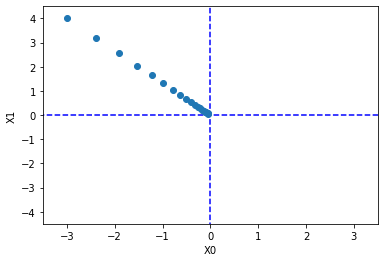

In [17]:
# 그래프
init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x, lr=0.1, step_num=20)

plt.plot([-5, 5], [0, 0], '--b')
plt.plot([0, 0], [-5, 5], '--b')
plt.plot(x_history[:, 0], x_history[:, 1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

## 4.5 학습 알고리즘 구현하기

'''
전제 : 신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 한다.  
신경망 학습은 다음과 같이 4단계로 수행한다.  
1단계 - 미니배치  
훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며,
그 미니배치의 손실함수 값을 줄이는 것이 목표이다.  
2단계 - 기울기 산출  
미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다.
기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.  
3단계 - 매개변수 갱신  
가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.    
4단계 - 반복  
1~3단계를 반복한다.  
데이터를 무작위로 선정하기 때문에 확률적 경사 하강법stochastic gradient descent,
SGD라고 부른다.
'''

In [25]:
import sys
import os
import numpy as np
sys.path.append(os.pardir)

### 에폭(epoch) 은 하나의 단위
시험데이터로 평가할때 1에폭은 학습에서 훈련데이터를 모두 소진했을 때의 회수에 해당한다.  
예를들어 훈련 10,000개를 100개의 미니배치로 학습할 경우, 확률적 경사 하강법을 100회 반복하면 모든 훈련 데이터를 '소진'한 게 된다.  
이 경우 100회가 1에폭이 된다.